In [69]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy


# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_1mmbin.h5","hits")

display(hits)


,event_id,x,y,z,energy
0,0,-7.327111,5.713126,3001.855957,0.003250
1,0,-8.715628,6.090691,3002.738281,0.000275
2,0,-9.061321,6.184691,3002.957764,0.000150
3,0,-10.505518,6.577397,3003.875488,0.001900
4,0,-12.979856,7.250218,3005.447510,0.001500
...,...,...,...,...,...
1010,9,-1.565342,6.041028,2994.065186,0.001400
1011,9,-0.816561,5.428232,2995.274170,0.001775
1012,9,0.132502,4.646546,2996.797607,0.000175
1013,9,0.946493,3.987114,2998.111816,0.002600


In [70]:
%matplotlib widget

data = hits[hits.event_id ==1]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Tunable parameters
init_dist_thresh = 5 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]

# Function to calculate the angle between two vectors
def calculate_angle(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    angle = np.arccos(dot_product / (norm_v1 * norm_v2))
    return angle

# Function to add connections made
# current and current node index is input
def UpdateConnections(curr_node_idx, conn_node_idx, connected_nodes_, connections_, connection_count_):

    # We shouldnt be doing any self connection
    if (curr_node_idx == conn_node_idx):
        return

    # Add connection between node i and closest_idx
    connections_.append((curr_node_idx, conn_node_idx))
    connection_count_[curr_node_idx] += 1
    connection_count_[conn_node_idx] += 1
    
    # Update connected nodes
    if i in connected_nodes_:
        connected_nodes_[curr_node_idx].append(conn_node_idx)
    else:
        connected_nodes_[curr_node_idx] = [conn_node_idx]
    
    if conn_node_idx in connected_nodes_:
        connected_nodes_[conn_node_idx].append(curr_node_idx)
    else:
        connected_nodes_[conn_node_idx] = [curr_node_idx]

# Function to check if a new connection would form a closed loop
def forms_cycle(node, target, connections_dict):

    query = node
    prev_node = node 
    # print(query)

    for index,n in enumerate(range(len(connections_dict))):
        
        # Get the connected nodes
        con_nodes = connections_dict[query]
        # print("Start",query, prev_node, con_nodes)

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return False

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]

        if (index == 0):
            query = con_nodes[0]
            prev_node = node


        # If the returned query value is the target then we have looped
        if (query == target):
            return True

    # We looped over everything and found no loops
    return False
    

# Find closest nodes and create connections
connections = []
for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            # Add connection between node i and closest_idx
            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        # Temporarily add the connection to check for cycles
                        temp_connections_dict = copy.deepcopy(connected_nodes)
                        temp_connections      = copy.deepcopy(connections)
                        temp_connection_count = copy.deepcopy(connection_count)

                        # print(i,closest_idx,connection_count[i], connection_count[closest_idx], temp_connections_dict[i], temp_connections_dict[closest_idx])
                        UpdateConnections(i, closest_idx, temp_connections_dict, temp_connections, temp_connection_count)

                        # Check for cycles
                        cycle = forms_cycle(i, closest_idx, temp_connections_dict)

                        temp_connections_dict = {}
                        temp_connections = []
                        temp_connection_count = []
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break

print(connected_nodes)

# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
# fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
# plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
# plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
# plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

# plt.tight_layout()
# plt.show()

# # Plot in 3D
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
# ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')
# for connection in connections:
#     start_node = connection[0]
#     end_node = connection[1]
#     ax.plot([data['x'][start_node], data['x'][end_node]],
#             [data['y'][start_node], data['y'][end_node]],
#             [data['z'][start_node], data['z'][end_node]], 'b-')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('3D Projection')
# plt.show()

,x,y,z,energy
0,5.393259,7.826430,3003.346924,0.005600
1,6.805379,8.825710,3005.459229,0.002175
2,8.133643,9.496508,3007.429199,0.000325
3,9.077716,9.976194,3008.851562,0.000075
4,10.375546,10.635626,3010.807129,0.001225
...,...,...,...,...
120,37.373425,45.760803,3006.455566,0.000600
121,37.718647,43.819462,3007.970947,0.001425
122,37.895954,39.124981,3012.188965,0.000225
123,38.018051,42.135780,3009.285156,0.000250


{0: [1], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [5, 3], 5: [4, 6], 6: [5, 9], 7: [8, 10], 8: [7, 13], 9: [18, 6], 18: [9, 21], 10: [11, 7], 11: [10, 12], 12: [11, 14], 13: [16, 8], 16: [13, 20], 14: [15, 12], 15: [14, 17], 17: [15, 19], 21: [18, 26], 19: [17, 24], 20: [16, 23], 22: [28, 25], 28: [22, 29], 23: [20, 27], 24: [19, 40], 25: [31, 22], 31: [25, 32], 26: [21, 38], 27: [30, 23], 30: [27, 39], 29: [28, 42], 32: [31, 37], 33: [34, 36], 34: [33], 35: [45, 41], 45: [35, 49], 36: [33, 47], 37: [32, 43], 38: [48, 26], 48: [38, 56], 39: [30, 54], 40: [44, 24], 44: [40, 61], 41: [35], 42: [29, 53], 43: [37, 46], 49: [45, 58], 46: [50, 43], 50: [46, 51], 47: [52, 36], 52: [47, 62], 56: [48, 65], 51: [50, 55], 53: [63, 42], 63: [53, 68], 54: [57, 39], 57: [54, 78], 55: [51, 59], 65: [56, 75], 58: [49, 66], 59: [60, 55], 60: [59, 62], 61: [73, 44], 73: [61, 82], 62: [60, 52], 68: [63, 76], 64: [67, 70], 67: [64, 69], 66: [72, 58], 72: [66, 77], 69: [67, 74], 70: [71, 64], 71: [70, 80], 74: 

[{'id': 0, 'start': 0, 'end': 34, 'nodes': [0, 1, 2, 3, 4, 5, 6, 9, 18, 21, 26, 38, 48, 56, 65, 75, 83, 86, 92, 94, 105, 109, 114, 116, 117, 119, 122, 124, 123, 121, 120, 118, 115, 113, 106, 102, 89, 78, 57, 54, 39, 30, 27, 23, 20, 16, 13, 8, 7, 10, 11, 12, 14, 15, 17, 19, 24, 40, 44, 61, 73, 82, 87, 88, 76, 68, 63, 53, 42, 29, 28, 22, 25, 31, 32, 37, 43, 46, 50, 51, 55, 59, 60, 62, 52, 47, 36, 33, 34], 'length': 187.282, 'energy': 0.126, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}, {'id': 2, 'start': 41, 'end': 79, 'nodes': [41, 35, 45, 49, 58, 66, 72, 77, 84, 90, 103, 107, 110, 111, 112, 108, 104, 101, 100, 97, 99, 98, 96, 95, 93, 91, 81, 74, 69, 67, 64, 70, 71, 80, 85, 79], 'length': 68.586, 'energy': 0.192, 'label': 'track', 'c': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)}]


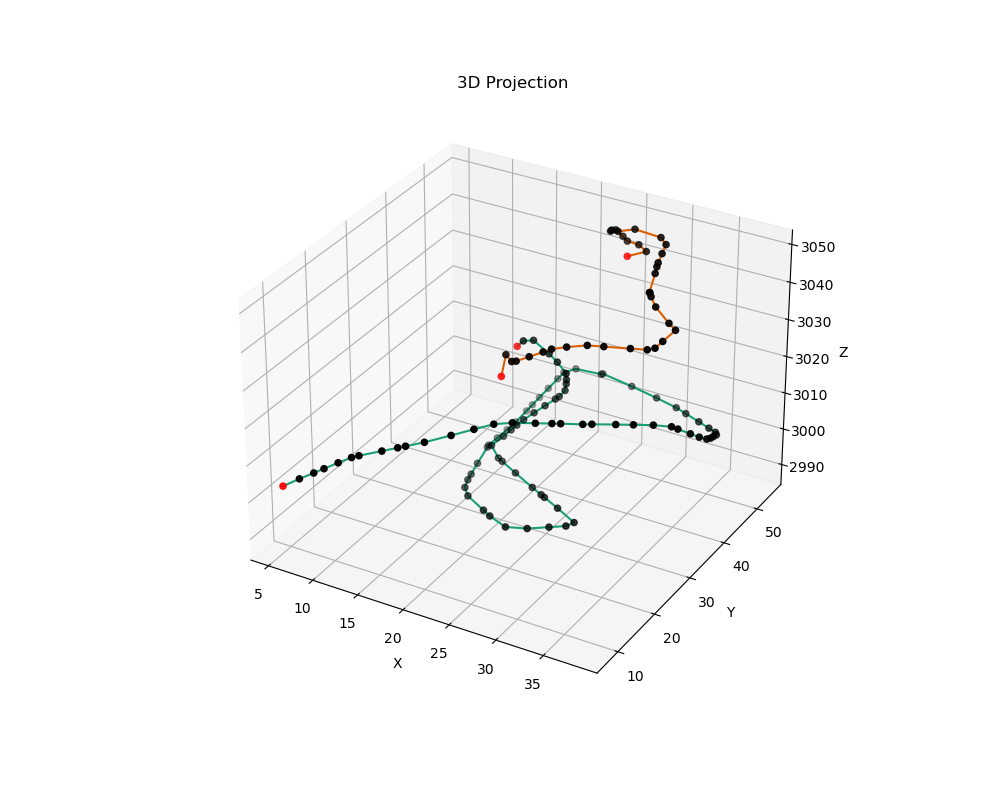

In [71]:
# Track building

# Function to walk along a track segment till we get to an end
def GetNodePath(graph, start_node, forward_node):
    path = [start_node]
    
    query = forward_node
    prev_node = start_node 

    for index,n in enumerate(range(len(graph))):

        path.append(query)
        
        # Get the connected nodes
        con_nodes = graph[query]

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return path

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]


    print("Error in pathing...")
    return path

def check_start_end_exists(number,Tracks):
    check_start = any(path["start"] == number for path in Tracks)
    check_end = any(path["end"] == number for path in Tracks)

    if (check_start or check_end):
        return True
    else:
        return False

# Function to calculate distance between two points
def calculate_distance(point1, point2):
    return np.sqrt((point2['x'] - point1['x'])**2 + (point2['y'] - point1['y'])**2 + (point2['z'] - point1['z'])**2)

# Get the length and energy of a track
def GetTrackLengthEnergy(path):
    total_length = 0
    total_energy = 0

    for t in range(len(path) - 1):
        point1 = data.iloc[path[t]]
        point2 = data.iloc[path[t + 1]]
        
        distance = calculate_distance(point1, point2)
        total_length += distance
        total_energy += point1['energy']
    
    # Add in the last energy hit
    total_energy += data.iloc[path[-1]]['energy']

    return round(total_length, 3), round(total_energy, 3)


colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)

print(Tracks)

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in Tracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

# print(Tracks[1]["nodes"])
# print(GetNodePath(connected_nodes, 32, 27))
# print(GetNodePath(connected_nodes, 32, 41))

0
Num new tracks: 2
The connecting track is: 2
Closest Index: 35
Segments: [35, 45, 49, 58, 66, 72, 77, 84, 90, 103, 107, 110, 111, 112, 108, 104, 101, 100, 97, 99, 98, 96, 95, 93, 91, 81, 74, 69, 67, 64, 70, 71, 80, 85, 79] [35, 41] [0, 1, 2, 3, 4, 5, 6, 9, 18, 21, 26, 38, 48, 56, 65, 75, 83, 86, 92, 94, 105, 109, 114, 116, 117, 119, 122, 124, 123, 121, 120, 118, 115, 113, 106, 102, 89, 78, 57, 54, 39, 30, 27, 23, 20, 16, 13, 8, 7, 10, 11, 12, 14, 15, 17, 19, 24, 40, 44, 61, 73, 82, 87, 88, 76, 68, 63, 53, 42, 29, 28, 22, 25, 31, 32, 37, 43, 46, 50, 51, 55, 59, 60, 62, 52, 47, 36, 33, 34, 35]
4.403
Len1: 2
Curr, Conn - Track,  0 2
[{'id': 0, 'start': 0, 'end': 34, 'nodes': [0, 1, 2, 3, 4, 5, 6, 9, 18, 21, 26, 38, 48, 56, 65, 75, 83, 86, 92, 94, 105, 109, 114, 116, 117, 119, 122, 124, 123, 121, 120, 118, 115, 113, 106, 102, 89, 78, 57, 54, 39, 30, 27, 23, 20, 16, 13, 8, 7, 10, 11, 12, 14, 15, 17, 19, 24, 40, 44, 61, 73, 82, 87, 88, 76, 68, 63, 53, 42, 29, 28, 22, 25, 31, 32, 37, 43, 46

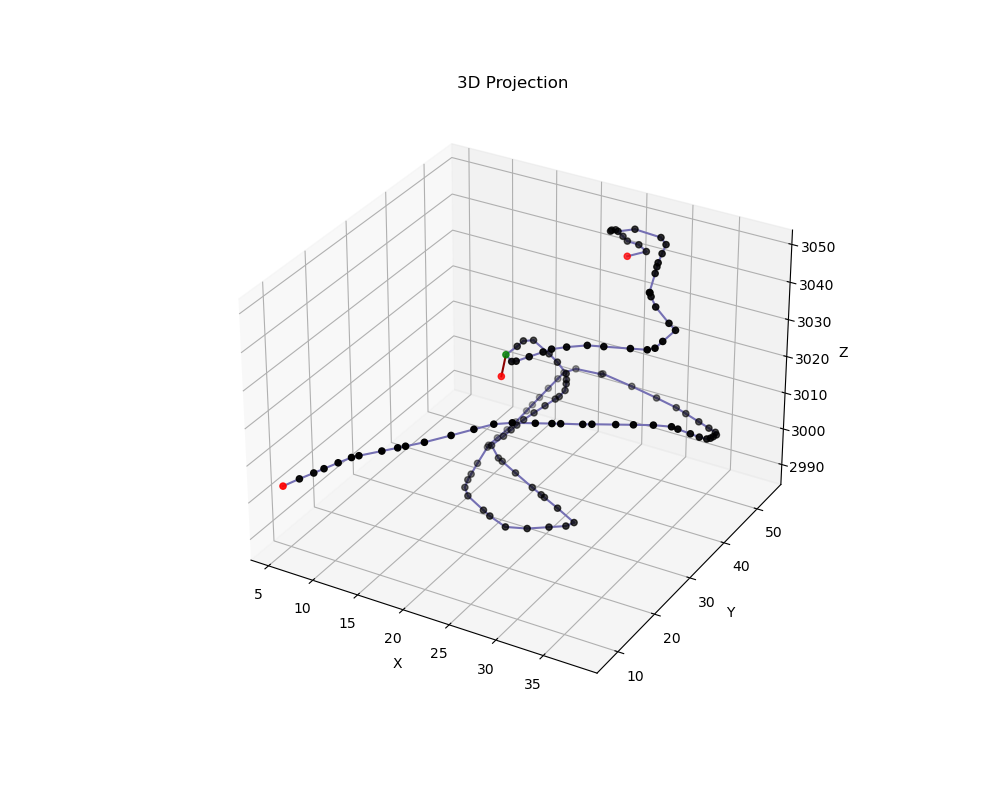

In [72]:
# Now look to merge tracks that are close by and identify deltas

def GetTrackwithNode(closest_idx, Tracks_):
    for t in Tracks_:
        if (closest_idx in t["nodes"]):
            return t["id"]
    # The node wasnt found anywhere...
    return -1

def GetTrackDictwithNode(closest_idx, Tracks_):
    for t in Tracks_:
        if (closest_idx in t["nodes"]):
            return t
    # The node wasnt found anywhere...
    return -1

def join_tracks(array1, array2):
    # Check if the arrays can be joined directly
    if array1[-1] == array2[0]:
        joined_array = array1 + array2[1:]
    elif array1[0] == array2[-1]:
        joined_array = array2 + array1[1:]
    # Check if reversing one of the arrays allows them to be joined
    elif array1[-1] == array2[-1]:
        array2_reversed = array2[::-1]
        joined_array = array1 + array2_reversed[1:]
    elif array1[0] == array2[0]:
        array1_reversed = array1[::-1]
        joined_array = array1_reversed + array2[1:]
    else:
        print("Error cannot join arrays")
        joined_array = array1 + array2  # If they can't be joined, just concatenate them

    return joined_array


def AddConnectedTracks(curr_track,conn_track, delta_path, seg1_path, seg2_path, UpdatedTracks):

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        
        # remove the old tracks
        if (t["id"] == curr_track):
            UpdatedTracks.pop(index)

    # Remove the old tracks from the array
    for index, t in enumerate(UpdatedTracks):
        # remove the old tracks
        if (t["id"] == conn_track):
            UpdatedTracks.pop(index)


    delta_len, delta_e = GetTrackLengthEnergy(delta_path)
    Delta = {"id":len(UpdatedTracks), "start":delta_path[0], "end":delta_path[-1], "nodes":delta_path, "length":delta_len, "energy":delta_e,"label":"delta","c":"darkred"}
    UpdatedTracks.append(Delta)
    
    joined_track_path = join_tracks(seg1_path, seg2_path)
    total_length_joined, total_energy_joined = GetTrackLengthEnergy(joined_track_path)
    color = next(color_cycle)
    
    Primary = {"id":len(UpdatedTracks), "start":joined_track_path[0], "end":joined_track_path[-1], "nodes":joined_track_path, "length":total_length_joined, "energy":total_energy_joined,"label":"track","c":color}
    UpdatedTracks.append(Primary)


# Update an existing track in the updated tracks array from the merging of two tracks
def UpdateAndMergeTrack(curr_track,conn_track, newpath, UpdatedTracks):
    
    for index, t in enumerate(UpdatedTracks):
        
        # remove the old tracks
        if (t["id"] == curr_track or t["id"] == conn_track):
            UpdatedTracks.pop(index)

    # Add the new merged track
    len, energy = GetTrackLengthEnergy(newpath)
    color = next(color_cycle)
    Primary = {"id":len(UpdatedTracks), "start":newpath[0], "end":newpath[-1], "nodes":newpath, "length":len, "energy":energy,"label":"track","c":color}
    UpdatedTracks.append(Primary)


def SearchDelta(Track_, UpdatedTracks_):
    start = Track_["start"]
    end   = Track_["end"]

    for index, t in enumerate(UpdatedTracks_):
        
        # Check to see if the current track ends matches with any tracks in the updated and it is flagged as a delta
        if (t["start"] == start or t["start"] == end or t["end"] == start or t["end"] == end):
            if (t["label"] == "delta"):
                return True
        
    return False



# UpdatedTracks = []
UpdatedTracks = copy.deepcopy(Tracks)

# Keep tabs of tracks that have already been added
TrackCounter = []

for idx, Track in enumerate(Tracks):
    curr_track = Track["id"]
    print(curr_track)
    print("Num new tracks:", len(UpdatedTracks))
    
    start_node = Track["start"]
    end_node   = Track["end"]

    # Check if the start/end is in the UpdatedTracks and if it matches to a delta
    if (SearchDelta(Track, UpdatedTracks)):
        print("Track is flagged as a connected delta, skipping...")
        continue


    TrackCounter.append(Track["id"])

    # dont run this if we only got one track!
    if (len(Tracks) == 1):
        break

    # Get the indexes of closest nodes to start and end
    dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
    dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

    # Filter nodes that are in the current track
    dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
    dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

    # Distances of the end point to the closest track
    dist_start = dist_matrix[start_node][dist_ind_start[0]]
    dist_end   = dist_matrix[end_node][dist_ind_end[0]]

    # apply threshold
    if (dist_start > dist_threshold and dist_end > dist_threshold):
        UpdatedTracks.append(Track)
        continue

    # Initialize
    closest_idx = 0
    end_conn_node = 0
    con_point = "start"
    curr_track_path = Track["nodes"]

    # Choose the smallest index
    if dist_start < dist_end:
        closest_idx = dist_ind_start[0]
        end_conn_node = start_node
        
    else:
        closest_idx = dist_ind_end[0]
        end_conn_node = end_node
        con_point = "end"

    # Get the track ID where the connecting node is located
    con_track      = GetTrackwithNode(closest_idx, Tracks)
    con_track_dict = GetTrackDictwithNode(closest_idx, Tracks)

    # if node-node then merge nodes and update track in Tracks
    if (closest_idx == con_track_dict["start"] or closest_idx == con_track_dict["end"]):
       newpath = join_tracks(con_track_dict["nodes"], curr_track_path)
       UpdateAndMergeTrack(curr_track, con_track, newpath, UpdatedTracks)
       UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
       continue


    # If forming a fork then need to re-classify track as usual


    # Check if the proposed connection will form a cycle
    # Temporarily add the connection to check for cycles
    temp_connections_dict = copy.deepcopy(connected_nodes)
    temp_connections      = copy.deepcopy(connections)
    temp_connection_count = copy.deepcopy(connection_count)

    UpdateConnections(end_conn_node, closest_idx, temp_connections_dict, temp_connections, temp_connection_count)

    # Check for cycles
    cycle = forms_cycle(end_conn_node, closest_idx, temp_connections_dict)

    temp_connections_dict = {}
    temp_connections = []
    temp_connection_count = []
    
    if not cycle:

        if (con_point =="start"):
            curr_track_path.insert(0,closest_idx)
        else:
            curr_track_path.append(closest_idx)

        Track["nodes"] = curr_track_path
        UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
    else:
        break


    # Get the length either side of track
    seg1_path = GetNodePath(connected_nodes, closest_idx, connected_nodes[closest_idx][0])
    seg2_path = GetNodePath(connected_nodes, closest_idx, connected_nodes[closest_idx][1])

    print("Segments:",seg1_path,seg2_path,curr_track_path)

    # Now get the lengths and energies of the track segments
    total_length_seg1, total_energy_seg1 = GetTrackLengthEnergy(seg1_path)
    total_length_seg2, total_energy_seg2 = GetTrackLengthEnergy(seg2_path) 
    total_length_seg3, total_energy_seg3 = GetTrackLengthEnergy(curr_track_path) 

    # Find the delta and the primary track and add them to the new track list
    if (total_length_seg1 < total_length_seg2 and total_length_seg1 < total_length_seg3):
        AddConnectedTracks(curr_track, con_track, seg1_path, seg2_path, curr_track_path, UpdatedTracks)
        TrackCounter.append(con_track)
    
    elif ((total_length_seg2 < total_length_seg1 and total_length_seg2 < total_length_seg3)):
        AddConnectedTracks(curr_track, con_track, seg2_path, seg1_path, curr_track_path, UpdatedTracks)
        TrackCounter.append(con_track)
    
    else:
        # Pop the track and re-add it with the new delta
        UpdatedTracks.pop(idx)
        Delta = {"id":len(UpdatedTracks), "start":curr_track_path[0], "end":curr_track_path[-1], "nodes":curr_track_path, "length":total_length_seg3, "energy":total_energy_seg3,"label":"delta","c":"darkred"}
        UpdatedTracks.append(Delta)

print("Total Tracks:", len(UpdatedTracks))
print(UpdatedTracks)


# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'g' if count == 3 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in UpdatedTracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

